In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models

## Dataset preparation

In [3]:
# Dummy datasets to see how it works
dummy_inputs = np.arange(6)
dummy_outputs = np.array([0, 1, 0, 1, 0, 1])

train_ds = tf.data.Dataset.from_tensor_slices((dummy_inputs, dummy_outputs))

#for item in train_ds:
#    print(item)

# Random shuffle
train_ds = train_ds.shuffle(buffer_size = 6) # buffer size = how many samples are included to shuffle

#for item in train_ds:
#    print(item)

In [4]:
def load_dataset_into_tfdata(set_range, paths, batch_size, shuffle = False, buffer_size = None):
    # set_range = set of setNo, i.e. which data should be loaded
    # Load data
    path_inputs, path_outputs = paths
    inputs = load_multi_datasets(path_inputs, set_range)
    outputs = load_multi_datasets(path_outputs, set_range)
    print('inputs shape = {}'.format(inputs.shape))
    print('outputs shape = {}'.format(outputs.shape))
    
    # Register in tfdata
    dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))
    # Random shufle
    if shuffle == True:
        dataset = dataset.shuffle(buffer_size = buffer_size) # buffer size = how many samples are included to shuffle
    # Batching
    dataset = dataset.batch(batch_size)
    
    return dataset
    
    
def load_multi_datasets(path, set_range):
    # set_range = set of setNo, i.e. which data should be loaded
    fname_all = []
    for setNo in set_range:
        # Get the file names for the current dataset
        curr_fname = '{}/setNo{}.npy'.format(path, setNo)
        # Append
        fname_all.append(curr_fname)
    # Load data
    dataset = np.array([np.load(fname) for fname in fname_all])
    
    return dataset
    

In [5]:
path_inputs = 'npy_data/ML/training/input_featuremapped'
path_outputs = 'npy_data/ML/training/outputs/fv_norm'
batch_size = 16

train_ds = load_dataset_into_tfdata(np.arange(50), [path_inputs, path_outputs], batch_size, shuffle = True, buffer_size = 20)
val_ds = load_dataset_into_tfdata(np.arange(100, 120), [path_inputs, path_outputs], batch_size)

inputs shape = (50, 9, 81)
outputs shape = (50, 25)
inputs shape = (20, 9, 81)
outputs shape = (20, 25)


In [6]:
N_input = 81
N_cddwindow = 3 # CNN window length = 10 neighboring bins are fed to estimate the FV of a single FV
N_output = 25

## Sequential graph with dense nets

In [7]:
inputs = keras.Input(shape = (N_input, ), name = 'Raw semi-vari')
x = layers.Dense(64, activation = "relu", kernel_regularizer = keras.regularizers.L1(0.01))(inputs)
x = layers.Dense(64, activation = "relu", kernel_regularizer = keras.regularizers.L1(0.01))(x)
outputs = layers.Dense(N_output)(x) # No activation

In [8]:
#model = keras.Model(inputs = inputs, outputs = outputs, name = 'fv_estimation')
#model.summary()

## Sequential graph with con1D nets / or autoencoder?

Idea: each frequency bin may not be totally independent, thus convolving the freq. resonse along the axis

In [9]:
inputs = keras.Input(shape = (N_cddwindow, N_input))
# (1) Mask to ignore the missing inputs
x = layers.Masking(mask_value = -1.0, input_shape = (N_cddwindow, N_input))(inputs)
# (2) 2-layer CNN
x = layers.Conv1D(32, 3, activation = "relu", kernel_regularizer = keras.regularizers.L1(0.01))(x)
#x = layers.MaxPooling1D()(x)
x = layers.Conv1D(32, 3, activation = "relu", kernel_regularizer = keras.regularizers.L1(0.01))(x)
#x = layers.MaxPooling1D()(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation = "relu", kernel_regularizer = keras.regularizers.L1(0.01))(x)
outputs = layers.Dense(N_output)(x) # No activation

In [10]:
model = keras.Model(inputs = inputs, outputs = outputs, name = 'fv_estimation')
model.summary()

Model: "fv_estimation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9, 81)]           0         
_________________________________________________________________
masking (Masking)            (None, 9, 81)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7, 32)             7808      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 32)             3104      
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                5152      
_________________________________________________________________
dense_4 (Dense)              (None, 25)              

## Model compile and fit

In [11]:
# Plot history
def plot_loss(history):
    plt.plot(history.history['loss'], label = 'loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error (MSE)')
    plt.legend()
    plt.grid(True)

In [12]:
def compile_and_fit(model, train_ds, val_ds, epochs):
    model.compile(
        optimizer = keras.optimizers.Adam(),
        loss = 'mean_squared_error'
    )
    
    history = model.fit(
        train_ds,
        validation_data = val_ds,
        epochs = epochs
    )
    return history


In [13]:
epochs = 50
history = compile_and_fit(model, train_ds, val_ds, epochs)

Epoch 1/50
4/4 [==============================] - 1s 128ms/step - loss: 13.1329 - val_loss: 12.5192
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 12.4053 - val_loss: 11.9762
Epoch 3/50
4/4 [==============================] - 0s 13ms/step - loss: 11.8180 - val_loss: 11.4501
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - loss: 11.2680 - val_loss: 10.9254
Epoch 5/50
4/4 [==============================] - 0s 14ms/step - loss: 10.7367 - val_loss: 10.4028
Epoch 6/50
4/4 [==============================] - 0s 13ms/step - loss: 10.2082 - val_loss: 9.8890
Epoch 7/50
4/4 [==============================] - 0s 14ms/step - loss: 9.7039 - val_loss: 9.3902
Epoch 8/50
4/4 [==============================] - 0s 14ms/step - loss: 9.1829 - val_loss: 8.9047
Epoch 9/50
4/4 [==============================] - 0s 14ms/step - loss: 8.6859 - val_loss: 8.4176
Epoch 10/50
4/4 [==============================] - 0s 14ms/step - loss: 8.1930 - val_loss: 7.9403
Epoch 11/50
4/4 [

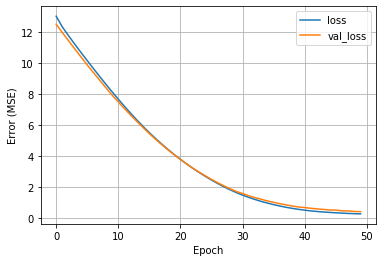

In [14]:
plot_loss(history)

In [15]:
model.save('tf_models/dummy')

INFO:tensorflow:Assets written to: tf_models/dummy\assets


## Make predictions

In [16]:
# Load test datasets
test_ds = load_dataset_into_tfdata(np.arange(200, 220), [path_inputs, path_outputs], batch_size)
# Evaluation
test_results = model.evaluate(test_ds, return_dict = True)

inputs shape = (20, 9, 81)
outputs shape = (20, 25)
2/2 [==============================] - 0s 2ms/step - loss: 0.2782


In [17]:
test_results

{'loss': 0.27815231680870056}

In [18]:
# Datasets
test_input = load_multi_datasets(path_inputs, np.arange(310, 320))
test_output = load_multi_datasets(path_outputs, np.arange(310, 320))

# prediction
test_pred = model.predict(test_input) # shape = n_samples x N_output

Text(0, 0.5, 'Normalized FV')

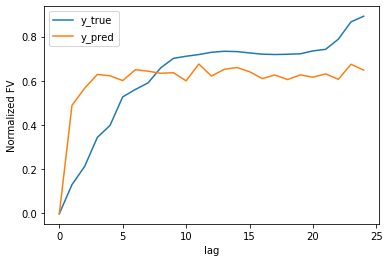

In [19]:
# true vs prediction
idx = 0
plt.plot(test_output[idx, :], label = 'y_true')
plt.plot(test_pred[idx, :], label = 'y_pred')
plt.legend()
plt.xlabel('lag')
plt.ylabel('Normalized FV')

## Training data size

In [20]:
sets_shallow = np.array([50, 30, 20]) # N_def = 2, 5, 10
sets_bottom = np.array([40, 20, 10])
n_batch = 5
n_freq = 25
n_ssmp = 20
n = (np.sum(sets_shallow) + 2* np.sum(sets_bottom))* n_batch* n_freq* n_ssmp
print(n)

600000


In [21]:
# Find out training data size
"""
with n = 650000
(*) train_reco:
    n x 100 x 2 (because complex) = 1 GB
(*) train_input:
    n x 10 x 88 (for conv1D) = 4.5 GB
(*) train_output:
    n x 25 = 127 MB = 0.127GB        
"""
#rng = np.random.default_rng()
#dummy_data = rng.random((n, 10, 88)) 
#np.save('dummy_data.npy', dummy_data)

'\nwith n = 650000\n(*) train_reco:\n    n x 100 x 2 (because complex) = 1 GB\n(*) train_input:\n    n x 10 x 88 (for conv1D) = 4.5 GB\n(*) train_output:\n    n x 25 = 127 MB = 0.127GB        \n'

## Custom loss function

In [22]:
def loss_fv_and_reco(y_true, y_pred):
    # Loss w.r.t. the FV
    loss_fv = np.linalg.norm(y_true - y_pred)**2
    
    # SAFT
    
    pass